# Dog Breed Prediction
# AI-0029

# Overview of the problem

This problem has two special features:
1. There are very few data per class to train the model. So, we have to use transfer learning in this problem.
2. The structure in which the train data is given, is not very convenient for keras.

To resolve the second point, we have two possible ways: 
1. Convert the images into numpy array or dataframe and then proceed as we do for numeric data
2. Rearrange the images inside their corresponding categorical folders and then use the built-in functions of keras for image classification.

To keep the main portion of the script generalized, I chose the 2nd.
    

Importing the dependencies:

In [2]:
import numpy as np 
import pandas as pd 
import os
from shutil import copyfile, copy
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Lambda
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import applications

C:\Users\Siam\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Set the directory paths and quantititive informations about the data

In [6]:
train_folder = 'dataset/train/train'
new_train_folder = 'dataset/train/category_train'
test_folder = 'dataset/test'
nb_train = 10222
nb_test = 10357

Now we need to create the new directories for keeping the images category-wise

In [7]:
df_train = pd.read_csv('labels.csv')
train_target = df_train['breed']
train_target = pd.get_dummies(train_target)
folder_list = train_target.columns

#make directories
if not os.path.exists(new_train_folder):
    os.makedirs(new_train_folder)    

#make category folders
for names in folder_list:
    if not os.path.exists(new_train_folder + '/' + names):
        os.makedirs(new_train_folder + '/' + names)
   

Now we need to copy the images into their new directories..

In [4]:
#copy images to the folders
print('Started Copying...')
for filename in tqdm(glob.glob(train_folder+ '/*.jpg')):
    image_name= os.path.basename(filename).replace(".jpg","")
    for x in range(len(df_train)):
        if (df_train.iloc[x].id == image_name):
            dst = new_train_folder + '/' + str(df_train.iloc[x].breed)
            copy(filename, dst)
            break
print('Finished Copying...')

Started Copying...


100%|██████████████████████████████████████████████████████████████████████████| 10222/10222 [1:11:08<00:00,  2.39it/s]


Finished Copying...


# Now, all being set, we are ready to go through the easy way for image classification

Using the ImageDataGenerator with flow from directory option. The parameters of the Generator are choosed logically.

In [8]:
train_datagen = ImageDataGenerator(
            rescale=1./255,
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.2, # Randomly zoom image 
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)  # randomly flip images

test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
        new_train_folder,
        target_size=(150, 150),
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        test_folder,
        target_size=(150, 150),
        class_mode = None)



Found 10222 images belonging to 120 classes.
Found 10357 images belonging to 1 classes.


Now, Let's build the model. Here, we will use the VGG19 model as our base and then add some layers on the top. We will first train the top layers only.

In [14]:
#Base part. Import pre-trained model
base_model = applications.vgg19.VGG19(include_top=False, weights='imagenet',input_shape=(150,150,3))

x = base_model.output
x = MaxPool2D(pool_size=(3,3))(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(120, activation='softmax')(x)


for layer in base_model.layers:
    layer.trainable = False
    
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy')

history = model.fit_generator(
        train_set,
        epochs=10,
        steps_per_epoch= 10222/32)


Epoch 1/10
317/319 [============================>.] - ETA: 32:22 - loss: 4.86 - ETA: 19:38 - loss: 4.95 - ETA: 15:21 - loss: 5.05 - ETA: 13:14 - loss: 5.03 - ETA: 11:56 - loss: 5.07 - ETA: 11:04 - loss: 5.11 - ETA: 10:26 - loss: 5.10 - ETA: 9:57 - loss: 5.1562 - ETA: 9:35 - loss: 5.161 - ETA: 9:17 - loss: 5.139 - ETA: 9:02 - loss: 5.144 - ETA: 8:49 - loss: 5.131 - ETA: 8:38 - loss: 5.146 - ETA: 8:28 - loss: 5.138 - ETA: 8:20 - loss: 5.129 - ETA: 8:12 - loss: 5.119 - ETA: 8:05 - loss: 5.118 - ETA: 7:59 - loss: 5.105 - ETA: 7:53 - loss: 5.084 - ETA: 7:47 - loss: 5.065 - ETA: 7:43 - loss: 5.056 - ETA: 7:38 - loss: 5.051 - ETA: 7:34 - loss: 5.039 - ETA: 7:30 - loss: 5.028 - ETA: 7:26 - loss: 5.020 - ETA: 7:22 - loss: 5.018 - ETA: 7:19 - loss: 5.008 - ETA: 7:16 - loss: 4.999 - ETA: 7:12 - loss: 4.991 - ETA: 7:09 - loss: 4.982 - ETA: 7:06 - loss: 4.984 - ETA: 7:03 - loss: 4.979 - ETA: 7:01 - loss: 4.977 - ETA: 6:58 - loss: 4.969 - ETA: 6:55 - loss: 4.961 - ETA: 6:53 - loss: 4.958 - ETA: 6:51

317/319 [============================>.] - ETA: 7:00 - loss: 4.537 - ETA: 7:01 - loss: 4.468 - ETA: 7:01 - loss: 4.565 - ETA: 7:02 - loss: 4.552 - ETA: 7:00 - loss: 4.550 - ETA: 6:59 - loss: 4.536 - ETA: 6:58 - loss: 4.523 - ETA: 6:56 - loss: 4.534 - ETA: 6:55 - loss: 4.528 - ETA: 6:53 - loss: 4.515 - ETA: 6:51 - loss: 4.498 - ETA: 6:50 - loss: 4.489 - ETA: 6:49 - loss: 4.491 - ETA: 6:47 - loss: 4.481 - ETA: 6:46 - loss: 4.473 - ETA: 6:44 - loss: 4.482 - ETA: 6:43 - loss: 4.474 - ETA: 6:41 - loss: 4.471 - ETA: 6:40 - loss: 4.474 - ETA: 6:39 - loss: 4.479 - ETA: 6:37 - loss: 4.484 - ETA: 6:36 - loss: 4.482 - ETA: 6:34 - loss: 4.479 - ETA: 6:33 - loss: 4.481 - ETA: 6:32 - loss: 4.481 - ETA: 6:30 - loss: 4.481 - ETA: 6:29 - loss: 4.473 - ETA: 6:27 - loss: 4.474 - ETA: 6:26 - loss: 4.479 - ETA: 6:25 - loss: 4.486 - ETA: 6:23 - loss: 4.489 - ETA: 6:22 - loss: 4.488 - ETA: 6:21 - loss: 4.484 - ETA: 6:19 - loss: 4.484 - ETA: 6:18 - loss: 4.477 - ETA: 6:17 - loss: 4.480 - ETA: 6:15 - loss: 4.4

320/319 [==============================] - ETA: 1s - loss: 4.402 - ETA: 0s - loss: 4.401 - 424s 1s/step - loss: 4.4016
Epoch 3/10
317/319 [============================>.] - ETA: 6:59 - loss: 4.087 - ETA: 6:58 - loss: 4.245 - ETA: 6:56 - loss: 4.206 - ETA: 6:56 - loss: 4.286 - ETA: 6:55 - loss: 4.276 - ETA: 6:55 - loss: 4.330 - ETA: 6:53 - loss: 4.298 - ETA: 6:52 - loss: 4.275 - ETA: 6:51 - loss: 4.287 - ETA: 6:50 - loss: 4.279 - ETA: 6:49 - loss: 4.272 - ETA: 6:48 - loss: 4.275 - ETA: 6:46 - loss: 4.269 - ETA: 6:45 - loss: 4.270 - ETA: 6:44 - loss: 4.275 - ETA: 6:42 - loss: 4.287 - ETA: 6:41 - loss: 4.280 - ETA: 6:40 - loss: 4.276 - ETA: 6:39 - loss: 4.278 - ETA: 6:37 - loss: 4.261 - ETA: 6:36 - loss: 4.258 - ETA: 6:35 - loss: 4.255 - ETA: 6:33 - loss: 4.252 - ETA: 6:32 - loss: 4.249 - ETA: 6:31 - loss: 4.250 - ETA: 6:30 - loss: 4.255 - ETA: 6:28 - loss: 4.245 - ETA: 6:27 - loss: 4.248 - ETA: 6:25 - loss: 4.254 - ETA: 6:24 - loss: 4.252 - ETA: 6:23 - loss: 4.250 - ETA: 6:21 - loss: 4.2

317/319 [============================>.] - ETA: 7:01 - loss: 4.590 - ETA: 7:00 - loss: 4.426 - ETA: 6:58 - loss: 4.349 - ETA: 6:56 - loss: 4.274 - ETA: 6:56 - loss: 4.191 - ETA: 6:54 - loss: 4.188 - ETA: 6:53 - loss: 4.132 - ETA: 6:51 - loss: 4.126 - ETA: 6:50 - loss: 4.108 - ETA: 6:49 - loss: 4.122 - ETA: 6:48 - loss: 4.132 - ETA: 6:47 - loss: 4.118 - ETA: 6:45 - loss: 4.083 - ETA: 6:44 - loss: 4.073 - ETA: 6:43 - loss: 4.071 - ETA: 6:41 - loss: 4.066 - ETA: 6:40 - loss: 4.068 - ETA: 6:39 - loss: 4.077 - ETA: 6:38 - loss: 4.099 - ETA: 6:36 - loss: 4.107 - ETA: 6:35 - loss: 4.113 - ETA: 6:34 - loss: 4.117 - ETA: 6:32 - loss: 4.115 - ETA: 6:31 - loss: 4.111 - ETA: 6:30 - loss: 4.124 - ETA: 6:28 - loss: 4.123 - ETA: 6:27 - loss: 4.121 - ETA: 6:26 - loss: 4.122 - ETA: 6:24 - loss: 4.115 - ETA: 6:23 - loss: 4.108 - ETA: 6:22 - loss: 4.114 - ETA: 6:20 - loss: 4.118 - ETA: 6:19 - loss: 4.121 - ETA: 6:18 - loss: 4.128 - ETA: 6:16 - loss: 4.122 - ETA: 6:15 - loss: 4.117 - ETA: 6:14 - loss: 4.1

320/319 [==============================] - ETA: 1s - loss: 4.112 - ETA: 0s - loss: 4.112 - 423s 1s/step - loss: 4.1118
Epoch 5/10
317/319 [============================>.] - ETA: 7:00 - loss: 4.079 - ETA: 6:59 - loss: 3.908 - ETA: 6:58 - loss: 3.976 - ETA: 6:58 - loss: 3.963 - ETA: 6:56 - loss: 4.023 - ETA: 6:55 - loss: 3.990 - ETA: 6:53 - loss: 4.006 - ETA: 6:52 - loss: 4.020 - ETA: 6:51 - loss: 4.052 - ETA: 6:49 - loss: 4.072 - ETA: 6:48 - loss: 4.076 - ETA: 6:47 - loss: 4.050 - ETA: 6:45 - loss: 4.038 - ETA: 6:44 - loss: 4.009 - ETA: 6:43 - loss: 4.011 - ETA: 6:41 - loss: 4.025 - ETA: 6:40 - loss: 4.012 - ETA: 6:39 - loss: 4.010 - ETA: 6:37 - loss: 4.012 - ETA: 6:36 - loss: 4.014 - ETA: 6:35 - loss: 4.019 - ETA: 6:34 - loss: 4.014 - ETA: 6:32 - loss: 4.010 - ETA: 6:31 - loss: 4.015 - ETA: 6:30 - loss: 4.019 - ETA: 6:28 - loss: 4.031 - ETA: 6:27 - loss: 4.026 - ETA: 6:26 - loss: 4.037 - ETA: 6:24 - loss: 4.026 - ETA: 6:23 - loss: 4.028 - ETA: 6:22 - loss: 4.027 - ETA: 6:20 - loss: 4.0

317/319 [============================>.] - ETA: 6:59 - loss: 3.999 - ETA: 6:56 - loss: 3.860 - ETA: 6:57 - loss: 3.858 - ETA: 6:57 - loss: 3.857 - ETA: 6:55 - loss: 3.867 - ETA: 6:54 - loss: 3.894 - ETA: 6:52 - loss: 3.880 - ETA: 6:51 - loss: 3.915 - ETA: 6:50 - loss: 3.967 - ETA: 6:49 - loss: 3.956 - ETA: 6:47 - loss: 3.946 - ETA: 6:46 - loss: 3.935 - ETA: 6:45 - loss: 3.961 - ETA: 6:43 - loss: 3.944 - ETA: 6:42 - loss: 3.922 - ETA: 6:41 - loss: 3.931 - ETA: 6:40 - loss: 3.933 - ETA: 6:39 - loss: 3.944 - ETA: 6:37 - loss: 3.954 - ETA: 6:36 - loss: 3.945 - ETA: 6:35 - loss: 3.940 - ETA: 6:33 - loss: 3.928 - ETA: 6:32 - loss: 3.935 - ETA: 6:30 - loss: 3.946 - ETA: 6:29 - loss: 3.955 - ETA: 6:28 - loss: 3.965 - ETA: 6:26 - loss: 3.977 - ETA: 6:25 - loss: 3.987 - ETA: 6:24 - loss: 3.986 - ETA: 6:22 - loss: 4.005 - ETA: 6:21 - loss: 3.993 - ETA: 6:20 - loss: 3.983 - ETA: 6:19 - loss: 3.987 - ETA: 6:17 - loss: 3.991 - ETA: 6:16 - loss: 3.991 - ETA: 6:15 - loss: 3.995 - ETA: 6:13 - loss: 3.9

320/319 [==============================] - ETA: 2s - loss: 3.993 - ETA: 0s - loss: 3.994 - 460s 1s/step - loss: 3.9934
Epoch 7/10
316/319 [============================>.] - ETA: 14:20 - loss: 3.75 - ETA: 13:11 - loss: 4.02 - ETA: 13:09 - loss: 3.99 - ETA: 13:03 - loss: 3.91 - ETA: 12:57 - loss: 3.90 - ETA: 12:47 - loss: 3.88 - ETA: 12:30 - loss: 3.89 - ETA: 12:24 - loss: 3.86 - ETA: 12:17 - loss: 3.86 - ETA: 11:48 - loss: 3.88 - ETA: 11:24 - loss: 3.85 - ETA: 11:00 - loss: 3.85 - ETA: 10:40 - loss: 3.86 - ETA: 10:22 - loss: 3.87 - ETA: 10:07 - loss: 3.85 - ETA: 9:56 - loss: 3.8690 - ETA: 9:44 - loss: 3.871 - ETA: 9:33 - loss: 3.881 - ETA: 9:23 - loss: 3.908 - ETA: 9:15 - loss: 3.903 - ETA: 9:06 - loss: 3.917 - ETA: 8:58 - loss: 3.917 - ETA: 8:51 - loss: 3.925 - ETA: 8:44 - loss: 3.920 - ETA: 8:37 - loss: 3.916 - ETA: 8:31 - loss: 3.917 - ETA: 8:26 - loss: 3.905 - ETA: 8:20 - loss: 3.908 - ETA: 8:15 - loss: 3.909 - ETA: 8:10 - loss: 3.901 - ETA: 8:06 - loss: 3.895 - ETA: 8:02 - loss: 3.

317/319 [============================>.] - ETA: 11:31 - loss: 3.97 - ETA: 10:29 - loss: 4.11 - ETA: 10:03 - loss: 4.09 - ETA: 10:11 - loss: 4.01 - ETA: 10:03 - loss: 3.96 - ETA: 9:59 - loss: 3.9333 - ETA: 10:10 - loss: 3.95 - ETA: 10:08 - loss: 3.95 - ETA: 10:03 - loss: 3.90 - ETA: 10:09 - loss: 3.92 - ETA: 9:51 - loss: 3.9202 - ETA: 9:43 - loss: 3.948 - ETA: 9:29 - loss: 3.964 - ETA: 9:17 - loss: 3.962 - ETA: 9:05 - loss: 3.971 - ETA: 8:56 - loss: 3.953 - ETA: 8:48 - loss: 3.960 - ETA: 8:40 - loss: 3.957 - ETA: 8:32 - loss: 3.958 - ETA: 8:26 - loss: 3.949 - ETA: 8:20 - loss: 3.949 - ETA: 8:14 - loss: 3.939 - ETA: 8:08 - loss: 3.941 - ETA: 8:03 - loss: 3.922 - ETA: 7:59 - loss: 3.916 - ETA: 7:54 - loss: 3.915 - ETA: 7:50 - loss: 3.923 - ETA: 7:46 - loss: 3.918 - ETA: 7:42 - loss: 3.918 - ETA: 7:39 - loss: 3.919 - ETA: 7:35 - loss: 3.910 - ETA: 7:32 - loss: 3.910 - ETA: 7:29 - loss: 3.913 - ETA: 7:25 - loss: 3.909 - ETA: 7:22 - loss: 3.917 - ETA: 7:19 - loss: 3.916 - ETA: 7:17 - loss: 3

320/319 [==============================] - ETA: 2s - loss: 3.905 - ETA: 0s - loss: 3.906 - 496s 2s/step - loss: 3.9058
Epoch 9/10
317/319 [============================>.] - ETA: 11:48 - loss: 3.62 - ETA: 12:51 - loss: 3.69 - ETA: 12:23 - loss: 3.75 - ETA: 11:52 - loss: 3.72 - ETA: 11:26 - loss: 3.67 - ETA: 11:07 - loss: 3.71 - ETA: 11:20 - loss: 3.67 - ETA: 11:26 - loss: 3.67 - ETA: 11:32 - loss: 3.64 - ETA: 11:37 - loss: 3.69 - ETA: 11:40 - loss: 3.70 - ETA: 11:38 - loss: 3.70 - ETA: 11:23 - loss: 3.69 - ETA: 11:10 - loss: 3.71 - ETA: 10:52 - loss: 3.70 - ETA: 10:35 - loss: 3.72 - ETA: 10:20 - loss: 3.74 - ETA: 10:10 - loss: 3.74 - ETA: 9:58 - loss: 3.7510 - ETA: 9:47 - loss: 3.754 - ETA: 9:37 - loss: 3.761 - ETA: 9:27 - loss: 3.748 - ETA: 9:18 - loss: 3.756 - ETA: 9:10 - loss: 3.748 - ETA: 9:03 - loss: 3.745 - ETA: 8:56 - loss: 3.738 - ETA: 8:49 - loss: 3.735 - ETA: 8:43 - loss: 3.743 - ETA: 8:37 - loss: 3.753 - ETA: 8:31 - loss: 3.752 - ETA: 8:26 - loss: 3.764 - ETA: 8:21 - loss: 3.

317/319 [============================>.] - ETA: 10:23 - loss: 3.77 - ETA: 10:42 - loss: 3.89 - ETA: 10:27 - loss: 3.77 - ETA: 10:21 - loss: 3.76 - ETA: 10:27 - loss: 3.75 - ETA: 10:27 - loss: 3.67 - ETA: 10:32 - loss: 3.68 - ETA: 10:30 - loss: 3.68 - ETA: 10:34 - loss: 3.72 - ETA: 10:28 - loss: 3.77 - ETA: 10:08 - loss: 3.78 - ETA: 9:53 - loss: 3.7786 - ETA: 9:38 - loss: 3.782 - ETA: 9:25 - loss: 3.796 - ETA: 9:14 - loss: 3.819 - ETA: 9:03 - loss: 3.815 - ETA: 8:57 - loss: 3.827 - ETA: 8:49 - loss: 3.826 - ETA: 8:41 - loss: 3.826 - ETA: 8:34 - loss: 3.824 - ETA: 8:27 - loss: 3.797 - ETA: 8:21 - loss: 3.800 - ETA: 8:16 - loss: 3.809 - ETA: 8:10 - loss: 3.816 - ETA: 8:05 - loss: 3.810 - ETA: 8:01 - loss: 3.814 - ETA: 7:56 - loss: 3.811 - ETA: 7:52 - loss: 3.812 - ETA: 7:48 - loss: 3.820 - ETA: 7:44 - loss: 3.811 - ETA: 7:40 - loss: 3.814 - ETA: 7:37 - loss: 3.825 - ETA: 7:33 - loss: 3.821 - ETA: 7:30 - loss: 3.828 - ETA: 7:27 - loss: 3.832 - ETA: 7:24 - loss: 3.829 - ETA: 7:21 - loss: 3.

320/319 [==============================] - ETA: 2s - loss: 3.829 - ETA: 0s - loss: 3.829 - 488s 2s/step - loss: 3.8282


CheckPoint: Save/Load from here if needed

In [4]:
#model.save('bottle_neck.h5')
model = load_model('bottle_neck.h5')

Let's Export the training curve.

Saved Graph


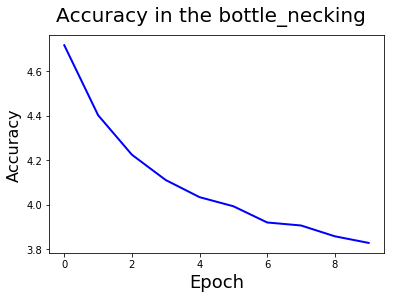

In [16]:
fig = plt.figure()
plt.plot( history.history['loss'], color='blue', linewidth=2)
fig.suptitle('Accuracy in the bottle_necking', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)
fig.savefig('bottle_neck_train.jpg')
print('Saved Graph')
plt.show()

Now we will go for fine tuning. Before that, we need to see the structure of the base model.

In [9]:
print('Started Prediction...')
ansr = model.predict_generator(
        test_set, steps= 10357/32, verbose=1)
print('Finished Prediction....')

Started Prediction...
324/323 [==============================] - ETA: 36:1 - ETA: 21:3 - ETA: 16:4 - ETA: 14:1 - ETA: 12:4 - ETA: 11:4 - ETA: 11:0 - ETA: 10:3 - ETA: 10:0 - ETA: 9:4 - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5

In [14]:
result = pd.DataFrame(ansr)
result.columns = folder_list
ID = test_set.filenames
for x in tqdm(range(len(ID))):
    ID[x]= os.path.basename(ID[x]).replace(".jpg","")
result.insert(0, 'id', ID)
result.to_csv('dog_prediction.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████| 10357/10357 [00:00<00:00, 113379.98it/s]


# Kaggle Score

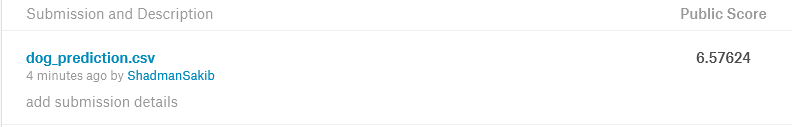